<a href="https://colab.research.google.com/github/XUideaList/Validating-Ampere-s-law-with-PINN/blob/main/UPRC_Validation_for_Ampere's_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before reading: Physics Experiments with Machine Learning - No.2
The idea of implementing Machine Learning and simulations in Undergrad Physics experiment courses originated from the lecture "Artificial Intelligence for Physicists" directed by Professor Q-Han Park at Korea University. Throughout the series of projects, I would like to assert that as the trend of research is now embracing Machine Learning, it is time for undergraduate students to learn about its concept and take advantage of it. For these purposes, I appended additional tasks to the experiment, asking students to come up with various creative ideas and indirectly experience how research is carried out.

#Verifying the validity of Ampere's law experimentally

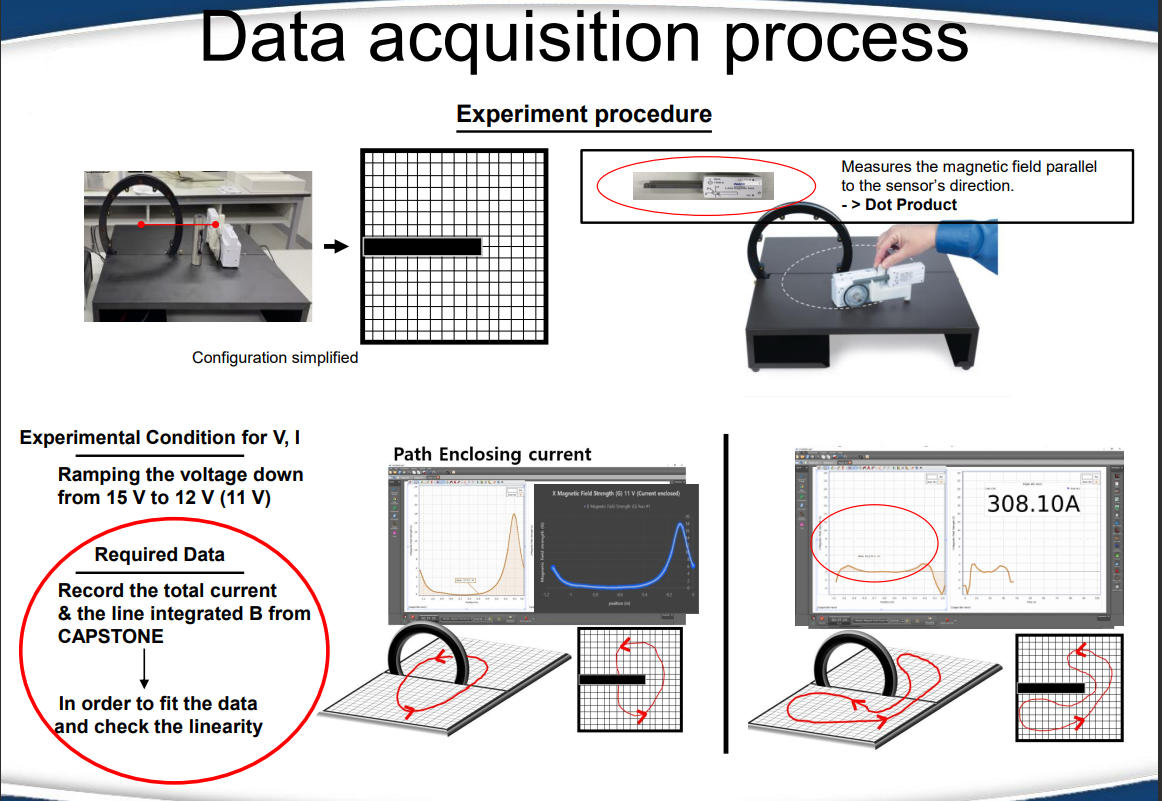

As shown in the figure above, The experiment tries to show the validity of Ampere's law by mounting a magnetic field sensor to a cart with a rotary sensor attached to its wheel. Using the CAPSTONE program, we can access the magnetic field strength data considering the distance the cart moved, i.e. the value of the path integrated field. Here the experiment requires the path-integrated field data for different paths, one with the path enclosing the coil and the other that doesn't. Eventually, we can validate Ampere's law (In the "Integration version") by comparing it with the acquired data.

# **Problem confrontation - Main Task**
However, such data are limited to the paths that the cart moved. The main point is we should show that consistency is yield for an arbitrary path and this is not feasible.

#**How are we going to resolve this matter?**

 **As our goal was validating Ampere's law, we don't need to stick with the integrated version but rather consider the derivative version.**

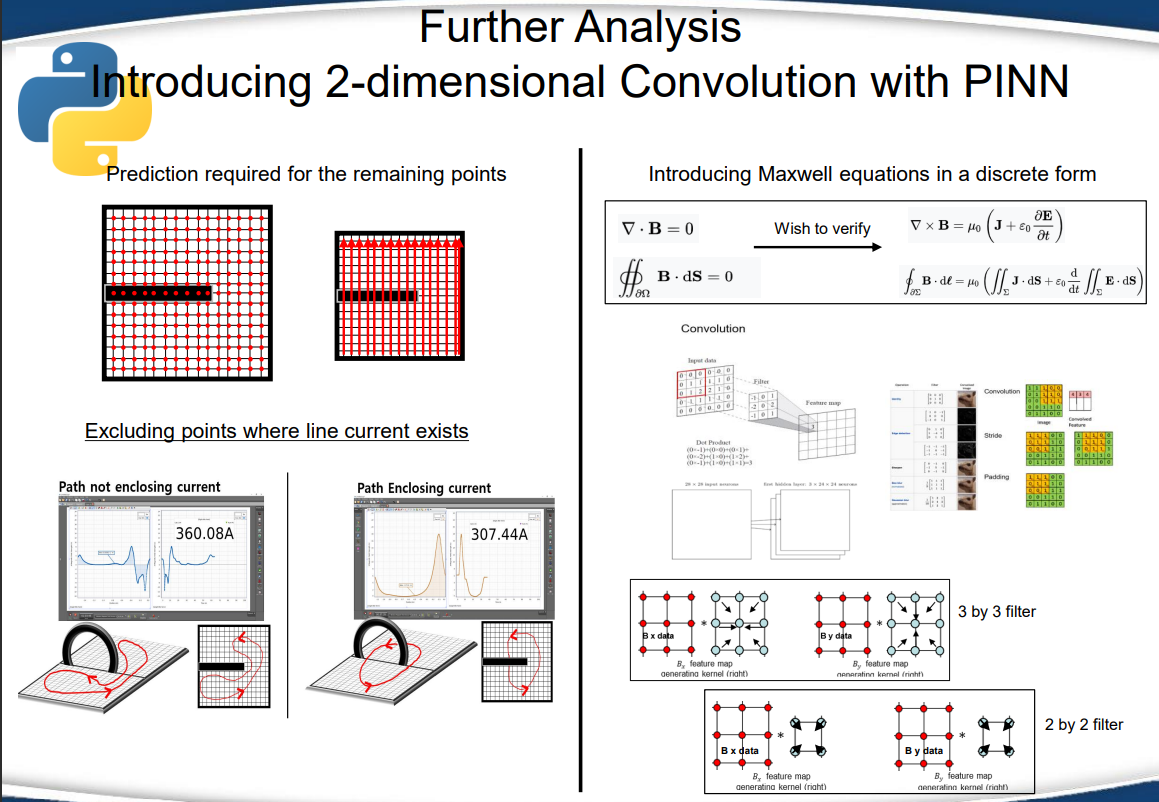

The data-collecting procedure would also be modified as shown in the figure above. We would be collecting a 10 by 10 grid B field vector data which would be a 2x10x10 tensor. Then, a 2-dimensional convolution will be introduced to compute the divergence of the magnetic field. It depends on one's choice to rather evaluate the divergence with numerical methods or apply the 2-dimensional version of the divergence theorem.

# **Problem Confrontation - Sub Task**
Again, one additional problem arises: There are not enough data points that enable the reliable calculation of divergence.

There are numerous methods of interpolation to fill up the vacant space. However, these methods do not consider the physics of magnetic fields. This is where we use **Machine Learning using PINN to inform the characteristics of a magnnetic field**

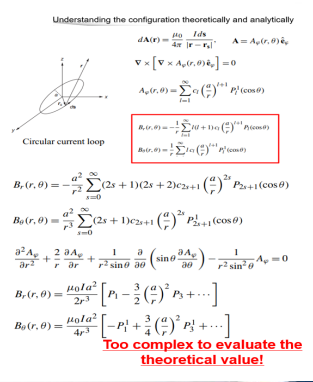

One would also expect additional merits. Since the field generated by a loop current is an infinite summation of **Associated Legendre** Polynomials, which is not easy to express numerically, ML may help the procedure of interpolation mimicking the complicated field structure. For study purposes, I will be using line currents for code development. Once the model achieves remarkable results, I will comeback implementing genuine experimental data.

# **Code Development**
The format of development would mainly focus on drawing students to run and revise the code with their original ideas. So most of the codes were tend to be developed mostly using user defined functions so that students can apply their ideas even if they are not familiar with the syntax of Python and Pytorch

We will first assume that the 10*10 grid data of the vector field is collected. Then, we will try to interpolate the field into some 2D square configuration using the variable "magnify num" which indicates the total number inserted between each grid point + 1. In my work, it is 7

In [1]:
from google.colab import drive # Students could link to Google Colab and save the outcomes in their drive.
drive.mount('/content/drive')

import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

Mounted at /content/drive


# Implementing Confiuration
Note that for brevity, the toy field will use fields originating from two line currents placed on the positions where the loop current meets the 2D configuration.

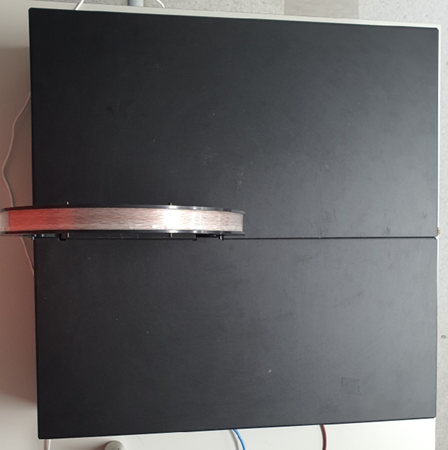


In [2]:
# Example Field
a = 0.10715 # m ,, radius
ring_w = 0.016 # m the width I assume.
W = 0.46 # m The side of the square plane
half_W = 0.23
slot_step = 10 #int(input(" How many data points collected in a n by n form:  "))
# This represents the number of data points that will be collected for a single row and the number of rows where the data will be collected.
d = W/slot_step # the interval between measured data points.
I_ampere = 400 # A, It's not the current itself that is actually yielding such value, but the product of the winding number and the actual current.
d1 = -W/10*2            #-0.0418*2      # the x-coordinate of the current line.
d2 =  0.15 -half_W/10   #-0.0209  # the x-coordinate of the other current line.

mu = 4*np.pi*10E-7 #H/m

print("The configuration has a size of %.2f (m) *%.2f (m).\nCurrent loop of width %.3f m and the radius in average as %.5f. "%(W,W,ring_w,a))
print("Required data points in total would be %d \nSo the width of the measuring points would be: %.3f.\nThe current is %.2f A"%(int(slot_step**2), d, I_ampere))


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device for computation: ", DEVICE)

The configuration has a size of 0.46 (m) *0.46 (m).
Current loop of width 0.016 m and the radius in average as 0.10715. 
Required data points in total would be 100 
So the width of the measuring points would be: 0.046.
The current is 400.00 A
Current Device for computation:  cpu


Field Data Format: [1, vector component, x_pos, y_pos],which is [1,2,10,10]


In [3]:
slot_num = 10 # Number of data points collected
interp_coeff = 6 # The number of interpolating data points between each data point

'''
WARNING: Due to the poisitions of the line currents listed below in curr_list, there are errors
when the interp_coeff becomes a odd_number (the interpolating point overlaps the position of the current source)
One can resolve such an error by adjusting the position of the current
This was intended to assure no singular fields when particularly using even numbered interp_coeff-s.
'''

magnify_num = interp_coeff+1 # the Magnifying constant: roughly ~ interpolated/ordinary in integer
interp_num = (slot_num-1)*magnify_num+1 # the total number of data points placed on one side of the square configuration.
# The total grid size would then be the square of: (slot_num-1)*interp_coeff + slot_num

slot_length = W/slot_num#0.418/slot_num
interp_length = slot_length/magnify_num

curr_list = [[d1,0,-I_ampere],[d2,0,I_ampere]]

print("interpolated plot- unit length: %.3f (m)"%interp_length)
print("The number of data points to be interpolated between each grid data: %d"%interp_coeff)

interpolated plot- unit length: 0.007 (m)
The number of data points to be interpolated between each grid data: 6


Defining the functions for field generation

Students do not have to worry about implementing the works that may be considered teious duch as generating fields in tensor-form data. They can just call the pre-defined function below.

In [4]:
def coord_maker(x_i,x_f, y_i,y_f, d_x, d_y, option = 0): # d_x, d_y is the interval between two data points for each the horizontal and vertical axis.
  # returns an output tnesor with a form of [2, N_x, N_y]
  x_list = np.arange(x_i, x_f, d_x)
  y_list = np.arange(y_i, y_f, d_y)

#  n_x, n_y = np.size(x_list), np.size(y_list)
  grid_x, grid_y = np.meshgrid(x_list, y_list)

  if(option):
    return np.asarray([grid_x, grid_y]), grid_x, grid_y
  else:
    return np.asarray([grid_x,grid_y])


def field_maker(coordinates, current_list):  # current_pos -> [current_num] -> [[x,y],[x2,y2],...]
  '''
  The function field_maker assumes that the field is generated by line currents perpendicular to the configuration.
  So please make sure that the information about the current sources are well defined.
  '''
  Bx, By = [],[]
  for idx_r1 in range(np.shape(coordinates)[1]):
    for idx_r2 in range(np.shape(coordinates)[2]):
      field_x, field_y = 0,0
      for idx_curr in range(len(current_list)):
        r_x = coordinates[0][idx_r1][idx_r2]-current_list[idx_curr][0]
        r_y = coordinates[1][idx_r1][idx_r2]-current_list[idx_curr][1]
        r_square = r_x**2+r_y**2

        field_x += -mu/(2*np.pi*r_square) * r_y * current_list[idx_curr][2]
        field_y += +mu/(2*np.pi*r_square) * r_x * current_list[idx_curr][2]

      Bx.append(field_x)
      By.append(field_y)

  Bx = np.reshape(np.asarray(Bx), (np.shape(coordinates)[1],np.shape(coordinates)[2]))
  By = np.reshape(np.asarray(By), (np.shape(coordinates)[1],np.shape(coordinates)[2]))

  Bx_tensor = torch.tensor(Bx, dtype = torch.float32)
  By_tensor = torch.tensor(By, dtype = torch.float32)
  B_total = ((torch.stack([Bx_tensor,By_tensor])).unsqueeze(0)).to(DEVICE)
  return B_total

def expand_field(fixed_field, vacant_field, magnify_num):
# This function generates a upsampled tensor with the given input, yet the un-measured points would remain to have zero fields
  for n in range(slot_num):  # height (N)
    for m in range(slot_num):  # width (M)
      vacant_field[0, :, magnify_num * n, magnify_num * m] = fixed_field[0, :, n, m]
  return vacant_field.to(DEVICE)

#Functions for Plots

similar to the description above, one does not have to worry about visualizing their ideas since there are functions that help plotting their work.

In [5]:
# Plots dots within the configuration that contains positions of the line currents.

def current_pos_plot(current_list, ax_curr):
  # position of the current lines
  pos_curr, neg_curr = [], []
  for curr_elem in current_list:
    if(curr_elem[-1]>=0):
      pos_curr.append(curr_elem)
    if(curr_elem[-1]<0):
      neg_curr.append(curr_elem)

  for pos_curr_elem in pos_curr:
    if(pos_curr_elem == pos_curr[-1]):
      ax_curr.scatter(pos_curr_elem[0], pos_curr_elem[1], color="red", s= 6, label="outcoming current")
    else:
      ax_curr.scatter(pos_curr_elem[0], pos_curr_elem[1], color="red", s= 6)

  for neg_curr_elem in neg_curr:
    if(neg_curr_elem == neg_curr[-1]):
      ax_curr.scatter(neg_curr_elem[0], neg_curr_elem[1], color="blue", s= 6, label = "ingoing current")
    else:
      ax_curr.scatter(neg_curr_elem[0], neg_curr_elem[1], color="blue", s= 6)

In [6]:
# plots the field and the points where interpolation should be carried out.
def interpolated_scale_plot(vector_field, input_coords, coord_X, coord_Y, ax_interp, plot_name = "Title", mag_option=magnify_num): # interp length and other variables are defined via magnify_num.
#if mag_option changes, the plot isn't what we have anticipated. Revise it if you have enough time

  if isinstance(vector_field, torch.Tensor):
    vector_field = vector_field.detach().cpu().numpy()

 # Create the figure and axes
  # fig, ax = plt.subplots()

  # plotting the space
  for index_pl1 in range(input_coords.shape[1]): # Or just use coord_config itself for the range
    for index_pl2 in range(input_coords.shape[2]):
      ax_interp.scatter(input_coords[0][index_pl1][index_pl2],input_coords[1][index_pl1][index_pl2], color='orange', s=5)
  ax_interp.scatter(input_coords[0][0][0],input_coords[1][0][0], color='orange', s=1, label='Training Points')

  # position of the current lines
  current_pos_plot(curr_list, ax_interp)
  # Plot the vector field
  scale=0.5
  #ax.quiver(X, Y, B_sh, B_sv)
  ax_interp.quiver(coord_X, coord_Y, vector_field[0,0,:,:], vector_field[0,1,:,:], label='B-field')

  # Set plot title and labels
  ax_interp.set_title("Interpolated field")
  ax_interp.set_xlabel("X")
  ax_interp.set_ylabel("Y")

  # Set aspect ratio to 'equal'
  ax_interp.set_aspect('equal')

  ax_interp.grid('on')
  ax_interp.set_xlabel('Horizontal (m)')
  ax_interp.set_ylabel('Vertical (m)')

  # Plotting the interpolated points
  if(mag_option>1):
    ax_interp.set_title("B-field configuration with magnification: %d"%mag_option)
    mag_coord = coord_maker((-interp_length*mag_option*2), (interp_length*mag_option*7+interp_length-err)
                                                          , (interp_length*mag_option*4+half_W/10),(-half_W/10-interp_length*mag_option*4-interp_length+err)
                                                          , interp_length, -interp_length)
    for index_pl3 in range(mag_coord.shape[1]):
      for index_pl4 in range(mag_coord.shape[2]):
        ax_interp.scatter(mag_coord[0][index_pl3][index_pl4],mag_coord[1][index_pl3][index_pl4], color='green', s=0.5)
    ax_interp.scatter(mag_coord[0][0][0],mag_coord[1][0][0], color='green', s=0.5, label='Divergence Evaluating Points')

  ax_interp.legend(loc=1, fontsize=6)
#  plt.show()

In [7]:
#plots tensors that contain vector field data
def field_plot(vector_field, coords, coord_X, coord_Y, ax_field, training_option=1 ,eval_option=0, plot_name = "Title"): # blue print, result
  # Create the figure and axes
  #fig, ax = plt.subplots() -> 1018 1458
  plt_mag = int((coords.shape[1]-1)/(slot_num-1))

  if isinstance(vector_field, torch.Tensor):
    vector_field = vector_field.detach().cpu().numpy()

  # position of the current lines
  current_pos_plot(curr_list, ax_field)

  # plotting the space
  if(eval_option):
    for index_pl3 in range(coords.shape[1]):
      for index_pl4 in range(coords.shape[2]):
        ax_field.scatter(coords[0][index_pl3][index_pl4],coords[1][index_pl3][index_pl4], color='green', s=0.5)
    ax_field.scatter(coords[0][0][0],coords[1][0][0], color='green', s=0.5, label='Divergence Evaluating Points')

  if(training_option):
    for index_pl1 in range(slot_num): # Or just use coord_config itself for the range
      for index_pl2 in range(slot_num):
        ax_field.scatter(coords[0][index_pl1*plt_mag][index_pl2*plt_mag],coords[1][index_pl1*plt_mag][index_pl2*plt_mag], color='orange', s=5)
    ax_field.scatter(coords[0][0][0],coords[1][0][0], color='orange', s=1, label='Training Points')

  # Plot the vector field
  scale=0.5
  #ax.quiver(X, Y, B_sh, B_sv)
  ax_field.quiver(coord_X, coord_Y, vector_field[0,0,:,:], vector_field[0,1,:,:], label='B-field') # Note that the toy data is stored in a form of 10x10x2 tensor

  # Set plot title and labels
  ax_field.set_title(plot_name+", Magnification:%d"%magnify_num)
  ax_field.set_xlabel("X")
  ax_field.set_ylabel("Y")

  # Set aspect ratio to 'equal'
  ax_field.set_aspect('equal')

  ax_field.grid('on')
  ax_field.set_xlabel('Horizontal (m)')
  ax_field.set_ylabel('Vertical (m)')

  ax_field.legend(loc=1, fontsize=6)
#  plt.show()

In [8]:
err = 0.0001 # For even number magnifying coefficients, there is an error for the number of the interpolated points.
# So I added a small number.

#Simple Situation. The code within this section is just showing how I managed to creat a toy field for the input.
coord_config, X, Y = coord_maker(-slot_length*2, slot_length*8, (slot_length*4+half_W/10), (-half_W/10-slot_length*5), slot_length, -slot_length,1)
fixed_field = field_maker(coord_config, curr_list)

interp_config, XX, YY = coord_maker((-interp_length*magnify_num*2), (interp_length*magnify_num*7+interp_length-err)
                                                          , (interp_length*magnify_num*4+half_W/10),(-half_W/10-interp_length*magnify_num*4-interp_length+err)
                                                          , interp_length, -interp_length, magnify_num)
true_field = field_maker(interp_config, curr_list)

In [9]:
# Obtained coordinates and its structure
fixed_Datapoint = np.asarray([X,Y])
interpolated_Datapoint = np.asarray([XX, YY])
# the collected field is assumed to be ->  fixed_field, having the same data shape with the prior coordinates

# This is just for plotting
fixed_plot=[coord_config[0],coord_config[1]]
interp_plot = [interp_config[0], interp_config[1]]

print("\nshape of the fixed_plot", np.shape(fixed_plot), "\n")
print("Shape of the input field",np.shape(fixed_field), "\n")
print("Shape of the fixed points",np.shape(fixed_Datapoint), "\n")
print("Shape of the interpolated plot",np.shape(interpolated_Datapoint))

# Interpolated plots, the data points are numpy arrays while the generated field / output of the model are torch.tensors.


shape of the fixed_plot (2, 10, 10) 

Shape of the input field torch.Size([1, 2, 10, 10]) 

Shape of the fixed points (2, 10, 10) 

Shape of the interpolated plot (2, 64, 64)


# True Field

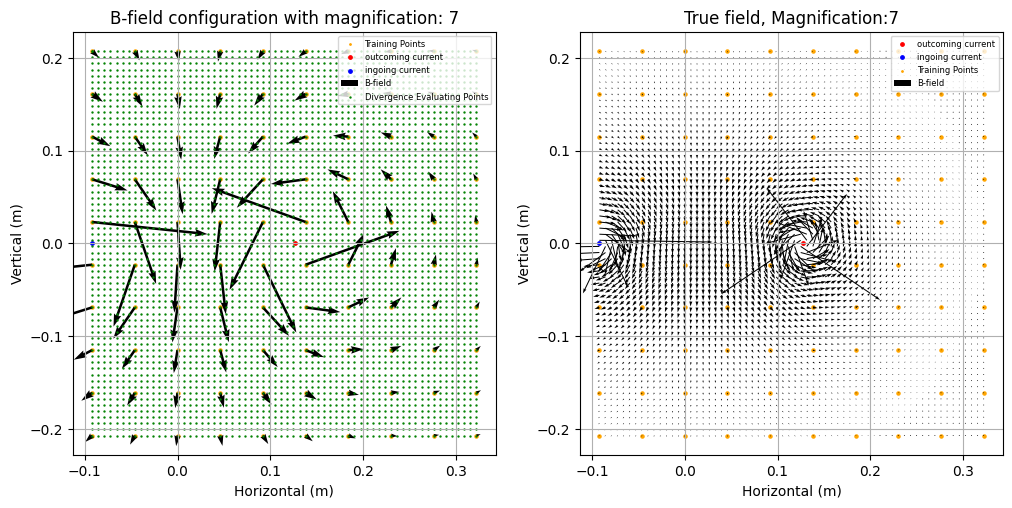

In [10]:
fig_true, ax_true = plt.subplots(1,2, figsize=(12,6))

# Plotting the input field with both training points and divergence evaluating points
interpolated_scale_plot(fixed_field, coord_config,  X, Y, ax_true[0], "Input Status-magnify_number: %d"%magnify_num)
# Plotting the resulted field with training points
field_plot(true_field, interp_config, XX, YY, ax_true[1], 1, 0, "True field")
plt.show()

With actual trials, it seems that plotting the eval points should be implemented only when plotting the input relation

# Convolution section for Evaluation indices

#**This section is required to be filled up by students providing several possible solutions partially or none to proceed**#

We could think of using different strides and different sizes of kernels to obtain different divergence maps and curl maps

Involving Physics for the kernels

* Exploiting the parity symmetry with respect to the plane of the configuration, the divergence theorem is held if it is valid on the plane of configuration. Remind this and consider the kernels to evaluate the divergence of the fields.

Defining kernels using loop-integration and FDM.
**Caution: Be aware that the units would differ each other due to different numerical methods and normalizations if one did not consider previously**

In [11]:
# Defining Kernels to compute derivatives of the vector field. It is a tedious process.

print("interpolating unit length: %.4f (m)"%interp_length)
dia = np.sqrt(1/2)*interp_length
#pent = np.sqrt(1/5)*interp_length
'''
Divergence Section * The  convoluted result should be divided by the area surrounded by the loop.
I left this part to remain as the loop integrated version but if one considers to compare this with the FDM method,
this should be considered.
'''

div_kernel_v=[[dia,1,dia],   [0,0,0],   [-dia,-1,-dia]]
div_kernel_h=[[-dia,0,dia],  [-1,0,1],    [-dia,0,dia]]
div_kernel_3 = ((torch.tensor([div_kernel_h,div_kernel_v], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)

# Curl Section
curl_kernel_h = [[-dia, -1, -dia], [0,0,0],  [dia, 1, dia]]
curl_kernel_v = [[-dia, 0, dia], [-1,0,1], [-dia, 0, dia]]
curl_kernel_3 = ((torch.tensor([curl_kernel_h, curl_kernel_v], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)


# FDM Version
#USING DIFFERENCES to Evaluate the direct Curl and Divergence of the field with convolution

# 3x3 Divergence Kernel
diff_div_h,diff_div_v = [[0,0,0], [-1,0,1], [0,0,0]], [[0,1,0], [0,0,0], [0,-1,0]] # It should be divided by 2
diff_div_3 = ((1 / (2*interp_length)) * torch.tensor([diff_div_h,diff_div_v], dtype=torch.float32).unsqueeze(0)).to(DEVICE)

# 3x3 Curl Kernel
diff_curl_h,diff_curl_v = [[0,-1,0], [0,0,0], [0,1,0]], [[0,0,0], [-1,0,1], [0,0,0]]
diff_curl_3 = ((1 / (2*interp_length)) * torch.tensor([diff_div_h,diff_div_v], dtype=torch.float32).unsqueeze(0)).to(DEVICE)


interpolating unit length: 0.0066 (m)


#Plotting and defining field_derivatives and its errors

Defining Convolution and Convolution layers for in/output vector fields

The convolution process itself doesn't take much time even for fields with magnfiy_num=7

In [12]:
def div_err(div_map): # div_map -> (1,interp_num, interp_num) shaped tensor denoting the divergence of the field.
  grid_number = div_map.numel()
  divergence_error = torch.mean((div_map**2)) # weighted by squaring the divergence so that large errors contribute more.
  # May have to remove the squaring operation since it may converge to a trivial solution.
  return divergence_error

def curl_sum(curl_map):
  pos_idx, neg_idx = curl_map > 0, curl_map < 0
  pos_curl, neg_curl = torch.sum(curl_map[pos_idx]), torch.sum(curl_map[neg_idx])
  sum_pos, neg_pos = torch.sum(pos_curl), torch.sum(neg_curl)
  return sum_pos, neg_pos

# Defining a layer to evaluate the Divergence/Curl of the in/output field is done in the following sections describing NN models.
# The input for this layer will be the predicted field. (Or the true field depending on occasions)

# Outside the model just for clarification.
def vector_field_conv(input_field, diff_kernel):
  #print(input_field.dtype, diff_kernel.dtype)
  convoluted_field = F.conv2d(input_field, weight=diff_kernel,stride=1, padding=0)#, groups=input_field.shape[0])
  return convoluted_field


# computations involving FDM kernels.
# The sections below can actually be replaced by using the VectorfieldConv class defined below. It's up to you.
def compute_div(field):
    # field: shape (batch_size, 2, H, W) - 2 corresponds to (Bx, By)
    # Apply the div_kernel_3 over the 2nd dimension (channel = 2, for Bx and By)
    diff_div_map = F.conv2d(field, diff_div_3, padding=0)
    return diff_div_map.to(DEVICE)

def compute_curl(field):
    # field: shape (batch_size, 2, H, W) - 2 corresponds to (Bx, By)
    # Apply the curl_kernel_3 over the 2nd dimension (channel = 2, for Bx and By)
    diff_curl_map = F.conv2d(field, diff_curl_3, padding=0)
    return diff_curl_map.to(DEVICE)

Plotting Divergence error maps and Curl maps


Input divergence error: 0.0000466
Total divergence error: 0.0000330
Perimeter of the current-enclosing path: %.3f (m) 0.05257142857142857
Max_curl value:  tensor(0.4475)
Mu_0 * Current:  0.005026548245743669


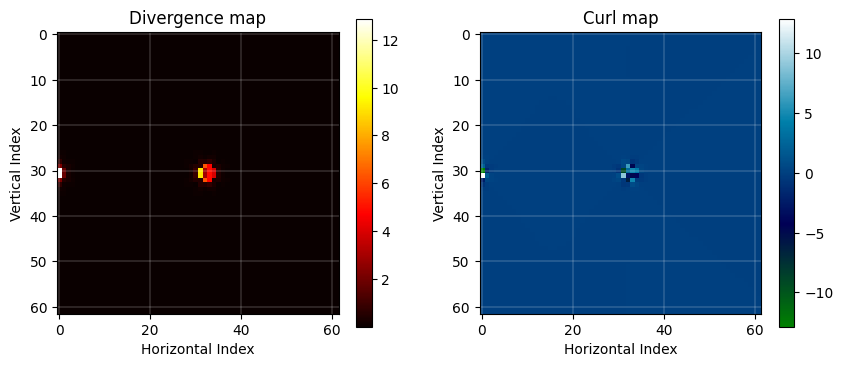

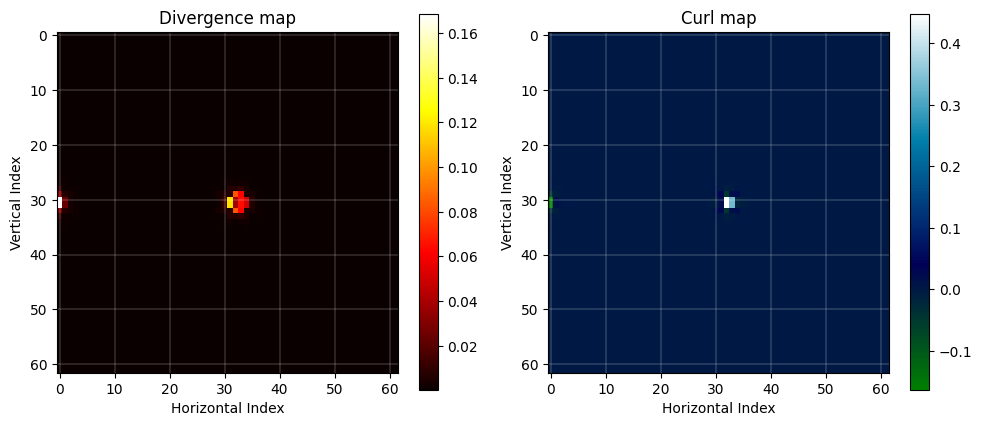

In [13]:
def portable_heatmap(map_data, ax_map, fig_map, plot_name = "map", c_option="hot", show_option=0):
  map_dist = map_data.squeeze().detach().cpu().numpy() # (1, 1, N, N) -> (N, N)

  # fig = plt.figure(figsize=(5,5))
  # ax = fig.add_subplot(111)
  # fig.suptitle(plot_name, fontsize = 15)

  cax_map = ax_map.imshow(map_dist, cmap = c_option)
  ax_map.set_title(plot_name)
  ax_map.set_xlabel("Horizontal Index")
  ax_map.set_ylabel("Vertical Index")
  ax_map.grid(True, color = "white", linewidth=0.2)

  # Colorbar
  fig_map.colorbar(cax_map, shrink = 0.8)

  if(show_option):
    #plt.figure(dpi=300)
    ax_map.show()


testing_div, testing_curl = torch.abs(vector_field_conv(true_field, div_kernel_3)), vector_field_conv(true_field, curl_kernel_3)
input_div, input_curl = torch.abs(vector_field_conv(fixed_field, div_kernel_3)), vector_field_conv(fixed_field, curl_kernel_3)

diff_interp_div, diff_interp_curl = torch.abs(compute_div(true_field)).to(DEVICE), compute_curl(true_field).to(DEVICE)
dif_test_map2, dif_axes_map2 = plt.subplots(1,2, figsize=(10,5))

'''
fig_test_map, axes_map = plt.subplots(1,2, figsize=(10,5))
portable_heatmap(input_div, axes_map[0], fig_test_map, "Input divergence map", "hot", 0)
portable_heatmap(input_curl, axes_map[1], fig_test_map, "Input curl map", "ocean", 0)

plt.tight_layout()
plt.show()
'''
print("Input divergence error: %.7f"%div_err(input_div))

out_curr, in_curr = curl_sum(testing_curl)
unit_interp_area = interp_length**2

print("Total divergence error: %.7f"%div_err(testing_div))
print("Perimeter of the current-enclosing path: %.3f (m)", 8*interp_length)

print("Max_curl value: ", torch.max(testing_curl))
#print("With CurlMap: Permeability times outgoing current: %.3f, ingoing current: %.3f"%(out_curr,in_curr))
print("Mu_0 * Current: ",mu*I_ampere)

fig_test_map2, axes_map2 = plt.subplots(1,2, figsize=(10,5))
portable_heatmap(testing_div, axes_map2[0], fig_test_map2,  "Divergence map","hot",0)
portable_heatmap(testing_curl,  axes_map2[1], fig_test_map2, "Curl map", "ocean",0)

portable_heatmap(diff_interp_div, dif_axes_map2[0], dif_test_map2,  "Divergence map","hot",0)
portable_heatmap(diff_interp_curl,  dif_axes_map2[1], dif_test_map2, "Curl map", "ocean",0)


plt.tight_layout()
plt.show()

Merging three plot functions into one, and a function that creates GIF when designating paths to save the file

In [14]:
def combined_plot(vector_field, coords, coord_X, coord_Y, map_data
                  ,plot_name=["Combined Plot","Combined Plot","Combined Plot"]
                  ,c_option_list=["hot"], overall_name="Plot Title", training_option=1, eval_option=0, show_option = 0):
    # Create figure with 1 row and 2 columns of subplots
    ax_num = 1 + len(map_data) # 1 field, several heat maps.
    fig_com, axes_com = plt.subplots(1, ax_num, figsize=(6*ax_num, 6))

    # Subplot for the field_plot
    plt.sca(axes_com[0])  # Set current axis to the first subplot
    field_plot(vector_field, coords, coord_X, coord_Y, axes_com[0], training_option, eval_option, plot_name[0])

    # Subplot for the portable_heatmap
    for map_No, maps in enumerate(map_data):
      plt.sca(axes_com[map_No+1])  # Set current axis to the second subplot
      portable_heatmap(maps, axes_com[map_No+1], fig_com, plot_name[map_No+1], c_option_list[map_No], 0)

    fig_com.suptitle(overall_name, fontsize = 15)

    # Show the combined plots
    if(show_option):
      plt.tight_layout()
      plt.show()

# Creating GIFs from multiple plots
from PIL import Image
def save_gif_PIL(outfile, files, fps=5, loop=0):  # call the function after adding a sseries of image composing the GIF.
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


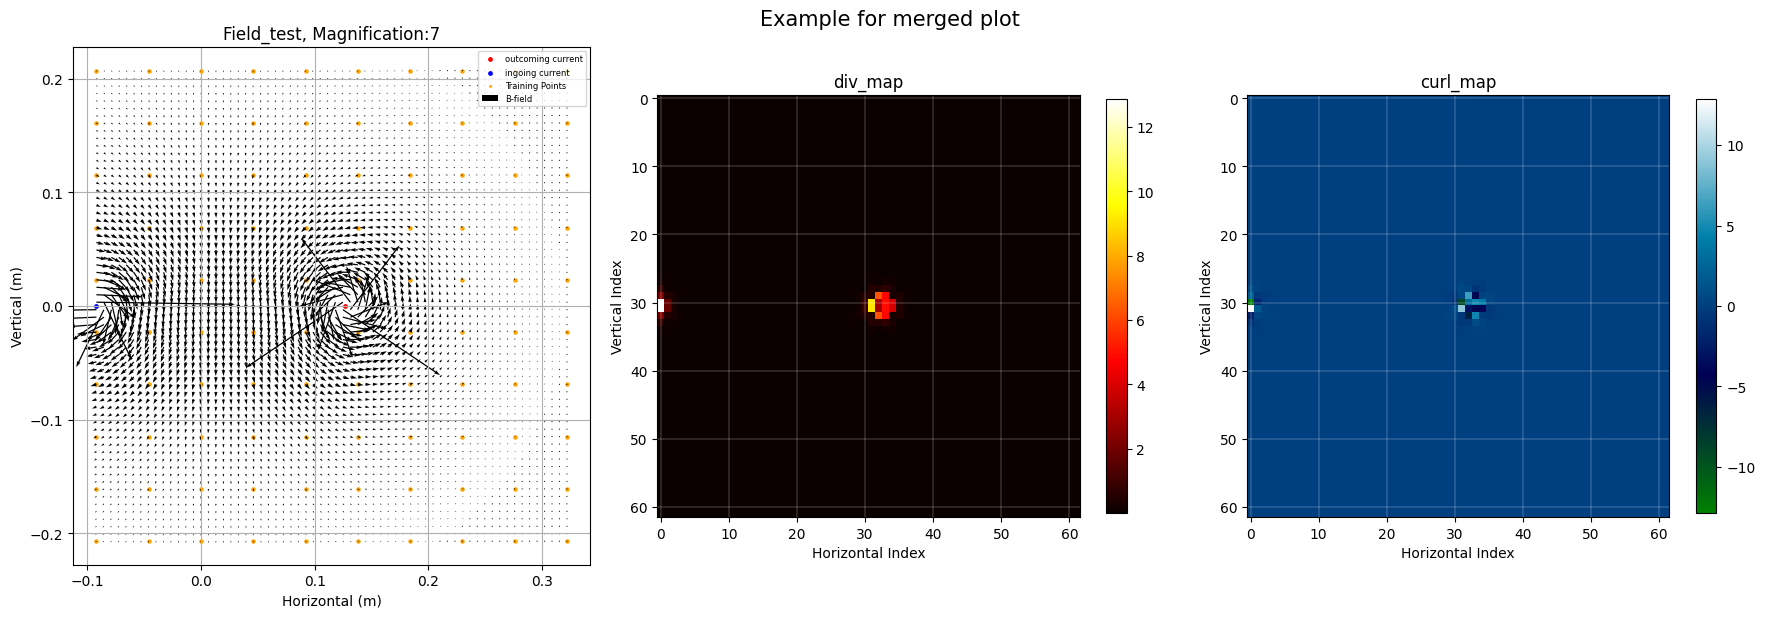

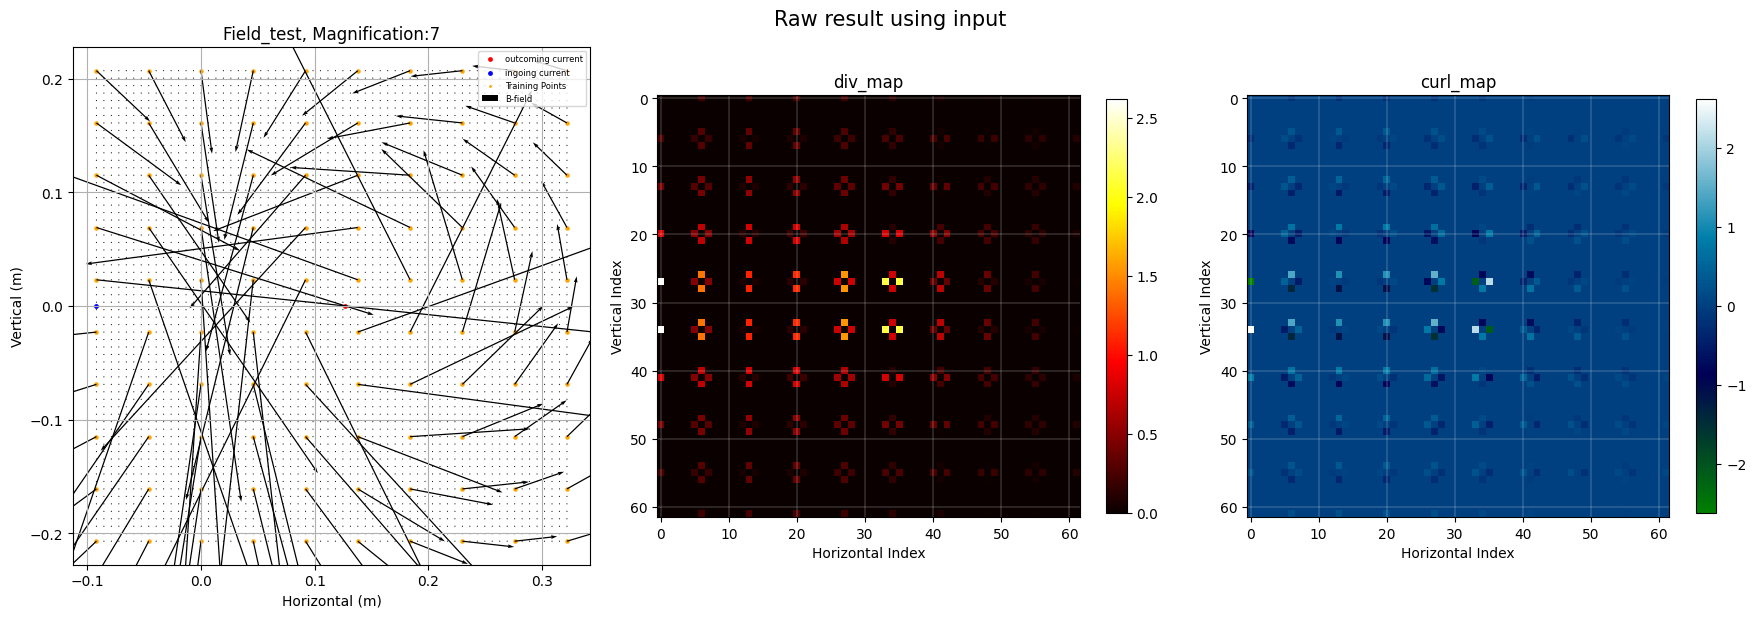

In [15]:
combined_plot(true_field, interp_config, XX, YY, [diff_interp_div, diff_interp_curl]
              , ["Field_test", "div_map","curl_map"], ["hot", "ocean"], "Example for merged plot")

plt.tight_layout()
plt.show()

vacant_fixed_field = torch.zeros((1, 2, interp_num, interp_num), dtype=fixed_field.dtype)
expanded_fixed_field = expand_field(fixed_field, vacant_fixed_field, magnify_num)
exp_div, exp_curl = torch.abs(compute_div(expanded_fixed_field)), compute_curl(expanded_fixed_field)

combined_plot(expanded_fixed_field, interp_config, XX, YY, [exp_div, exp_curl]
              , ["Field_test", "div_map","curl_map"], ["hot", "ocean"], "Raw result using input")

plt.tight_layout()
plt.show()


Defining a function to generate GIFs

#Designing our NN model
**This part yields the highest degree of freedom for students to design their ideas.** One can design the structure of the NN based on their strategy training the NN they have created. **In my case, I will be implementing a 2-dimensional PINN using \vec{\nabla}\cdot\vec{B}=\vec{0} \

In [16]:
# Extracting points with tensor inputs.
def extract_error(pred_tensor, training_tensor, magnify_coeff=magnify_num, log_option = 0):
    mse_x = mse_y = 0
    check_list = [[], []]

    # comparing_tensor의 크기를 가져오기
    height, width = training_tensor.shape[2:4]
    for coord_x in range(height):
        for coord_y in range(width):
            # Extract values
            pred_value_x = pred_tensor[0, 0, coord_x * magnify_coeff, coord_y * magnify_coeff]
            pred_value_y = pred_tensor[0, 1, coord_x * magnify_coeff, coord_y * magnify_coeff]
            comparing_value_x = training_tensor[0, 0, coord_x, coord_y]
            comparing_value_y = training_tensor[0, 1, coord_x, coord_y]

            # Evaluate the MSE for training points
            mse_x += (comparing_value_x - pred_value_x) ** 2
            mse_y += (comparing_value_y - pred_value_y) ** 2

            # Append MSE to check_list for accession to the error log
            check_list[0].append(mse_x.item())  # tensor -> scalar
            check_list[1].append(mse_y.item())

    if(log_option):
      return torch.mean(mse_x+mse_y), check_list  # return it into scalar
    else:
      return torch.mean(mse_x+mse_y)

class Vectorfield_conv(nn.Module):
  def __init__(self, diff_kernel): # diff_kernel form: (torch.tensor([diff_kernel_x,diff_kernel_y]))
    super(Vectorfield_conv, self).__init__()
    self.kernel = diff_kernel # (1, 2, W_x, W_y) form kernel -> 2 input Channels(x,y comp of the vector field), 1 output (divergence, curl)
    self.conv = nn.Conv2d(in_channels=2, out_channels=1  # In : 2*interp_num*interp_num // Out: 1*m*m
                          ,kernel_size =(self.kernel.shape[2], self.kernel.shape[3])
                          ,stride = 1 ,padding = 0 # kernel size: m -> 2*(interp_num-m+1)*(interp_num-m+1)
                          ,bias=False)

    with torch.no_grad():
      self.conv.weight = nn.Parameter(self.kernel)

  def forward(self, x):
    x = self.conv(x)
    return x

# Checking the Error for ficed points when a zero field is fed.
test_zero_field = (torch.zeros(1,2,interp_num,interp_num)).to(DEVICE)

#extract_example, extract_example_list = extract_error(test_zero_field, fixed_field, magnify_num, 1)
#print(extract_example)

div_map_3_gen = Vectorfield_conv(div_kernel_3).to(DEVICE)
curl_map_3_gen = Vectorfield_conv(curl_kernel_3).to(DEVICE)

The structure of the NN here is ill-constructed. No poolings nor deep layers and reasonable layer sizes. **Students can benchmark from well-known models such as GoogLeNet and so on**

In [17]:
# 2-3 CNN model
# This model is literally just nothing but a model with few layers stacked with no intention
# # Good results are expected from modifying the structure

class B_FieldInterpolator_Mk3(nn.Module):
  def __init__(self, input_size, output_size):
# Increasing the Kernel size for a certain layer would involve broader tendencies.
    super(B_FieldInterpolator_Mk3, self).__init__()
    self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)
    self.upsample = nn.Upsample(size = (output_size,output_size)
                               ,mode='bilinear', align_corners=True)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.upsample(x)
    x = self.conv3(x)
    return x

# Example usage
model_Mk3 = B_FieldInterpolator_Mk3(slot_num, interp_num).to(DEVICE)

# Training Procedure & Resulted output

The optimizer and learning rates should be adjusted with the user's range of values. This could also be an extension of the experimental procedure

Current Date: yr:2024, 10/23. Current time: 26:18
Initiate Ampere's law validation program.


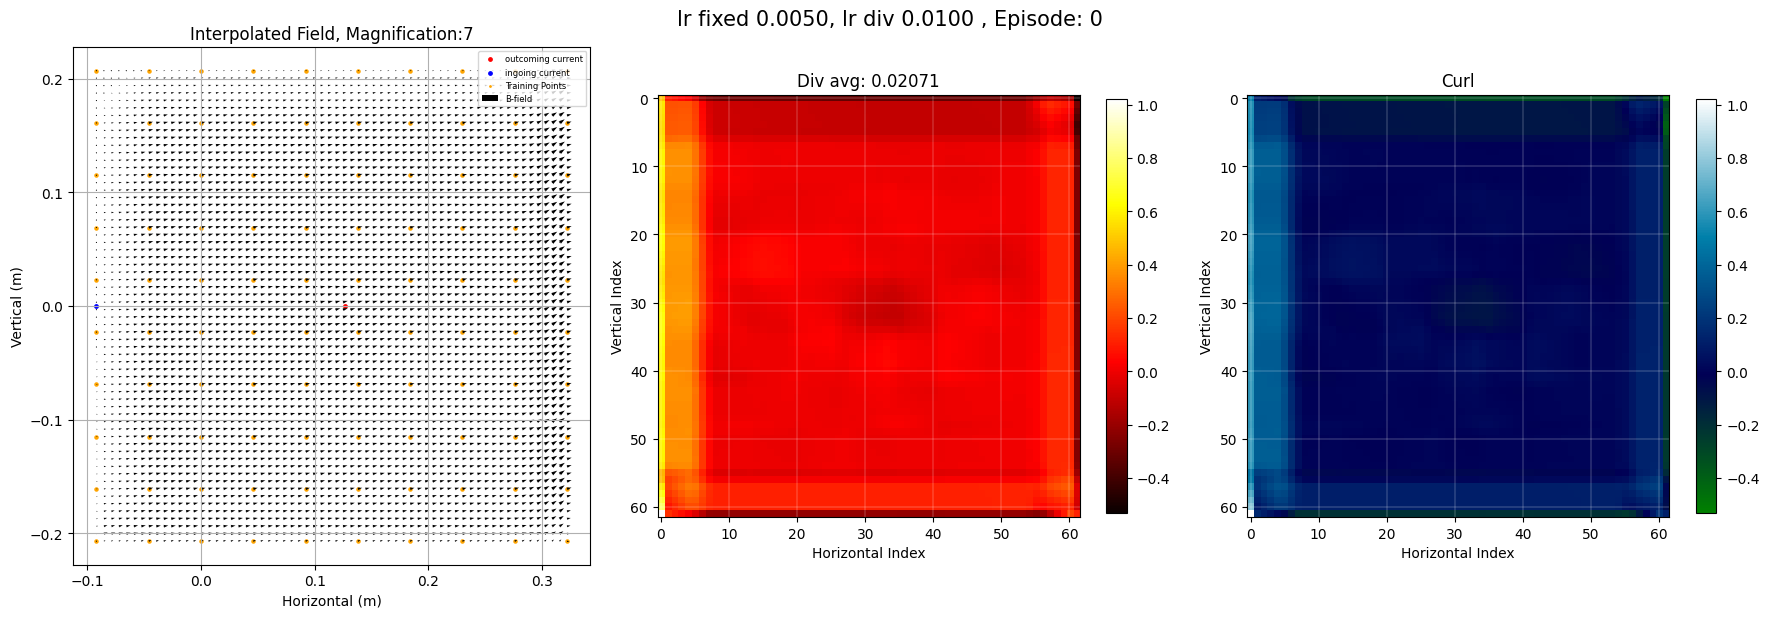

Completed. Duration: 1635.35 (s)


In [20]:
%matplotlib inline
time_in_list = list(time.localtime()[0:5]) # South Korea - reference time
time_in_list[3] = time_in_list[3]+9

print("Current Date: yr:%d, %d/%d. Current time: %d:%d"%tuple(time_in_list[0:5]))
print("Initiate Ampere's law validation program.")

model = model_Mk3

torch.manual_seed(1024)
episodes = 20000 # Total number of interpolations.
num_plots = 200 # Number of plots

# 3. Define Loss and Optimizer -> 10.22 update: Changed the kernels based on FDM.
lr_fixed = 0.005  #.006 .006,.004(null) 0.0035 0.0035 0.005 0.002 0.005
lr_divergence = 0.01  #.002 .01,.01(null) 0.01 0.03 1 0.05 0.005 -> 1:1 ratio seemed to look good... but it drastically collapses

# Optimizer: ADAM
optimizer = optim.Adam(model.parameters(), lr=lr_fixed)

#input("file name to store the GIF") -> Create a folder named as the variable "file_name" in files of Colab
file_name = "gif folder"
# Designate the path to store the GIF and its name in gif_name
gif_path = "/content/drive/MyDrive/Colab Notebooks/KPS UPRC/ "
gif_name = gif_path+"Loop integration - time : %dth %d:%d, lr: (%.4f,%.4f)"%(time_in_list[2],time_in_list[3],time_in_list[4],lr_fixed,lr_divergence)

files = []
fixed_err_list, physics_loss_list, tot_err_list = [] , [],  []

start_time = time.perf_counter()
for interp_iteration in range(episodes):

  optimizer.zero_grad()  # Initialize gradient to 0

  # Forward Pass -> Predict Field
  interpolated_output = model(fixed_field)

  # Calculate field derivatives
  interpolated_divergence = compute_div(interpolated_output)#compute_div(interpolated_output) # div_map_3_gen(interpolated_output)
  interpolated_curl = compute_curl(interpolated_output)#compute_curl(interpolated_output)# curl_map_3_gen(interpolated_output)

  # Compute loss and BackPropagate
  fixed_point_err = extract_error(interpolated_output,fixed_field)
  interpolated_div_error = div_err(interpolated_divergence)

  final_loss = fixed_point_err + interpolated_div_error*lr_divergence
  final_loss.backward() # BPP
  optimizer.step() # Update

  fixed_err_real = fixed_point_err.detach().cpu().numpy()
  interpolated_div_err_real = interpolated_div_error.detach().cpu().numpy()
  tot_err_real = fixed_err_real + lr_divergence * interpolated_div_err_real

  fixed_err_list.append(fixed_err_real)
  physics_loss_list.append(interpolated_div_err_real)
  tot_err_list.append(tot_err_real)

# The if phrase can be neglected if one desires for a faster calculation
  if( (interp_iteration % (episodes/num_plots))==0 ):
    # Append plot of the interpolated field for trial No.: interp_iteration
    combined_plot(interpolated_output, interp_config, XX, YY, [interpolated_divergence, interpolated_curl]
                  ,["Interpolated Field"
                  ,"Div avg: %.5f"%interpolated_div_err_real,"Curl"]
                  ,['hot','ocean'],"lr fixed %.4f, lr div %.4f , Episode: %d"%( lr_fixed, lr_divergence ,interp_iteration))
    plt.tight_layout()

    #print("Fixed_data error: %.8f, Physics error: %.8f in total %.8f for episode : %d "%(fixed_err_real, interpolated_div_err_real, tot_err_real, interp_iteration))
    file = file_name+"/Interp_%.8i.png"%(interp_iteration)
    plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=200, facecolor='white')
    files.append(file)

    if((interp_iteration % (episodes)) == 0):
      plt.show() #One can think of plt.clf()
    else: plt.close("all")

end_time =  time.perf_counter()
print("Completed. Duration: %.2f (s)"%(end_time-start_time))

Plot error

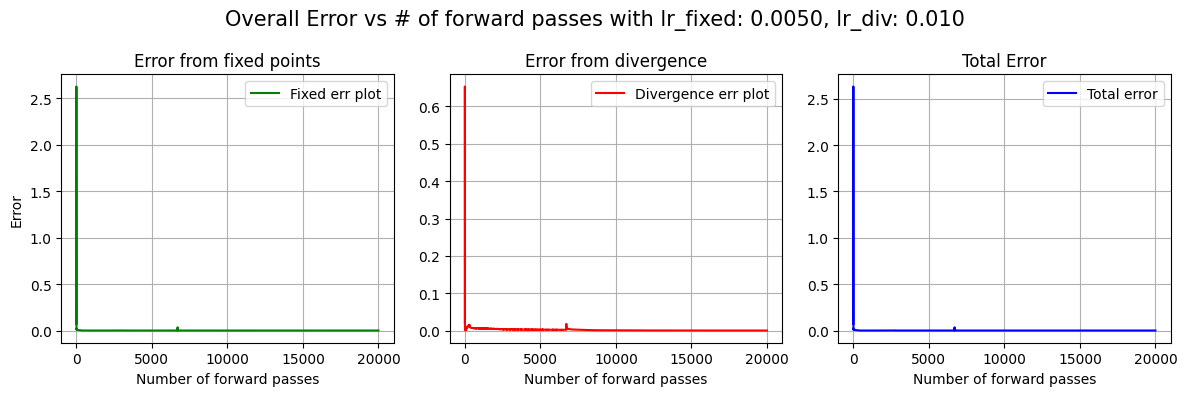

In [21]:
#Plotting error history
fixed_err_list = np.asarray(fixed_err_list)
physics_lost_list = np.asarray(physics_loss_list)
tot_err_list = np.asarray(tot_err_list)

fig_err, ax_err = plt.subplots(1,3, figsize=(12,4))

ax_err[0].plot(fixed_err_list, label = "Fixed err plot", color = "green")
ax_err[0].set_xlabel("Number of forward passes")
ax_err[0].set_ylabel("Error")
ax_err[0].set_title("Error from fixed points")
ax_err[0].grid()
ax_err[0].legend()

ax_err[1].plot(physics_lost_list, label = "Divergence err plot", color="red")
ax_err[1].set_xlabel("Number of forward passes")
#ax_err[1].set_ylabel("Error")
ax_err[1].set_title("Error from divergence")
ax_err[1].grid()
ax_err[1].legend()

ax_err[2].plot(tot_err_list, label = "Total error", color = "blue")
ax_err[2].set_xlabel("Number of forward passes")
#ax_err[2].set_ylabel("Error")
ax_err[2].set_title("Total Error")
ax_err[2].grid()
ax_err[2].legend()

fig_err.suptitle("Overall Error vs # of forward passes with lr_fixed: %.4f, lr_div: %.3f"%(lr_fixed, lr_divergence), fontsize = 15)
fig_err.tight_layout()

plt.show()

Save GIF

In [22]:
savePlot_option =input("Would you like to save the results? Y:1 , N:0 >> ")

# Change of Interpolated Field, Divergence and Curl
# adjust the fps value.
if(savePlot_option):
  save_gif_PIL(gif_name, files, fps=10, loop=0)

# Change the path to save the error plot in a different file.
  err_path = "/content/drive/MyDrive/Colab Notebooks/KPS UPRC/"
  fig_err.savefig(err_path+" Error plot : %dth %d:%d, lr:(fixed,div)= (%.4f,%.4f).png"%(time_in_list[2],time_in_list[3],time_in_list[4],lr_fixed,lr_divergence))

Would you like to save the results? Y:1 , N:0 >> 0


#Plot & Analyze the  Curl map

One can now analyze if the region without current has a curl value near zero or analyze the region with a nonzero current proportional to the current value of that certain point

In [23]:
curl_max = torch.max(interpolated_curl)
curl_avg = torch.mean(interpolated_curl)

print("curl_max: %.5f, curl_avg:%.5f"%(curl_max, curl_avg))

# Positive curl (interpolated_curl > 0)
positive_elements = interpolated_curl[interpolated_curl > 0]

# Negative curl (interpolated_curl < 0)
negative_elements = interpolated_curl[interpolated_curl < 0]

print("avg of pos curl: ", torch.mean(positive_elements))
print("avg of neg curl: ", torch.mean(negative_elements))

curl_max: 0.18251, curl_avg:-0.00012
avg of pos curl:  tensor(0.0136, grad_fn=<MeanBackward0>)
avg of neg curl:  tensor(-0.0155, grad_fn=<MeanBackward0>)


# Updates that can be made to improve the interpolation procedure

# Implying other loss functions that contain more physics such as exploiting symmetries (To Be Developed)

# Changing Collected Data points -> Boundary conditions taken into account (To Be Developed)

# Physical Interpretation of the results in the experiment session


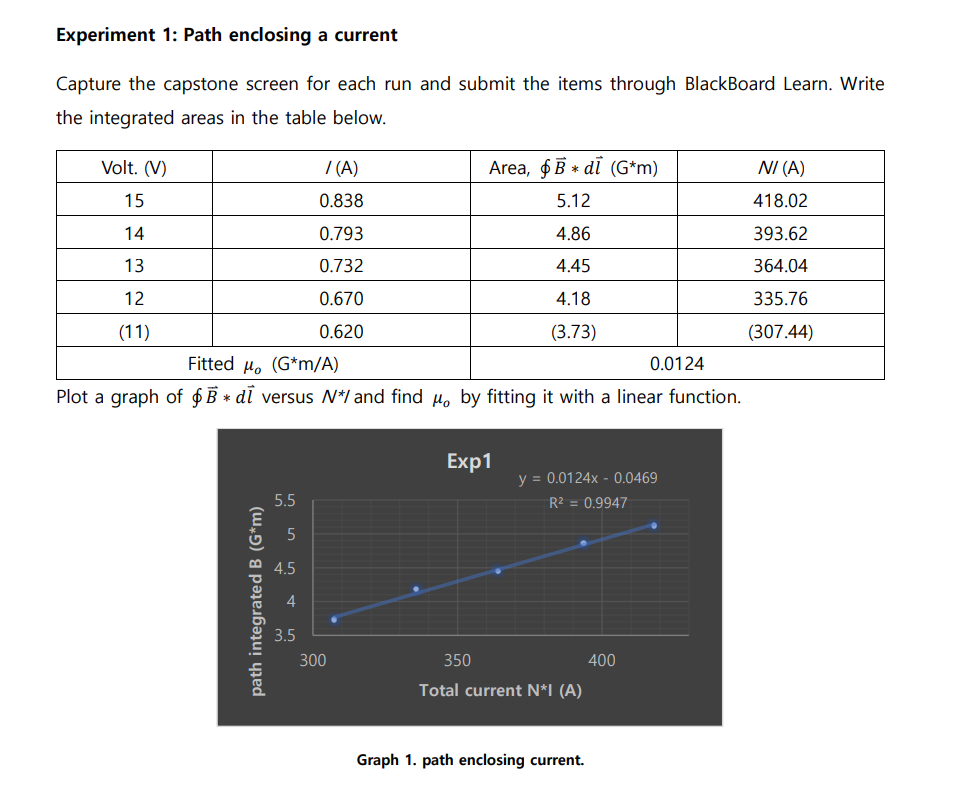

* Error bars are required when one is willing to use the data in offcial reports and research for integrity.

*Refer to https://docs.google.com/spreadsheets/d/1fd1RoHTrA-LQs3Di2oDhoObfbsI2rEpM/edit?usp=drive_link&ouid=107840157351743673732&rtpof=true&sd=true for more data and details of the curl and divergence data for different current and interpolation coefficient
